# A Simple Multi-Class Text Classification with Transformers

Transformers have now become the main pillar for most of the Natural Language Processing tasks (NLP), like sentiment analysis, natural language generation, named entity recognition.

In this post, I want to share a simple and easy guide for those who are just getting started in the area of language processing. The task we are going to solve is know as text classification or text tagging, where the goal is to categorize text into organized groups (e.g. sentiment, product categories, gender).

The dataset we will use is the [emotion-cause dataset](https://www.site.uottawa.ca/~diana/resources/emotion_stimulus_data/#:~:text=The%20Emotion%20Cause%20dataset%20contains,the%20end%20of%20the%20span.&text=The%20tags%20indicates%20the%20cause,of%20the%20sentence%20%E2%80%94%20Happiness%20here.), which contains 2414 sentences tagged with emotion. The main reasons to use this dataset are: (1) to show you that you don't need huge datasets with thousands of records to build a good classifier, and (2) it contains 7 classes, as far as I know, the current tutorials focus on two classes and without the background in NLP or Machine Learning (ML) is hard to pass from a binary classification to a multi-class classifications.

Lets start!



## Data preparation
The first step is to download our dataset and pre-prosed it. The preprocess_emotion_casuse.py script that I created will generate the standard input for the function [tf.keras.preprocessing.text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) which returns a [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) that yields batches of texts from the subdirectories.
 
The [tf.keras.preprocessing.text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) exptect a ditectiry containing subdirectories (one per class) each containing text files for a class.

emotion_directory/<br>
...emotion_a/<br>
......a_text_1.txt<br>
......a_text_2.txt<br>
...emotion_b/<br>
......b_text_1.txt<br>
......b_text_2.txt<br>

In [1]:
import shutil
from xml.dom import minidom

# download dataset & unzip dataset
! wget http://www.eecs.uottawa.ca/~diana/resources/emotion_stimulus_data/Dataset.zip
shutil.unpack_archive('Dataset.zip')

! python preprocess_emotion_casue.py --input_path Dataset

--2021-07-09 02:59:33--  http://www.eecs.uottawa.ca/~diana/resources/emotion_stimulus_data/Dataset.zip
Resolving www.eecs.uottawa.ca (www.eecs.uottawa.ca)... 137.122.24.222
Connecting to www.eecs.uottawa.ca (www.eecs.uottawa.ca)|137.122.24.222|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://www.site.uottawa.ca/~diana/resources/emotion_stimulus_data/Dataset.zip [following]
--2021-07-09 02:59:33--  http://www.site.uottawa.ca/~diana/resources/emotion_stimulus_data/Dataset.zip
Resolving www.site.uottawa.ca (www.site.uottawa.ca)... 137.122.24.222
Reusing existing connection to www.eecs.uottawa.ca:80.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.site.uottawa.ca/~diana/resources/emotion_stimulus_data/Dataset.zip [following]
--2021-07-09 02:59:33--  https://www.site.uottawa.ca/~diana/resources/emotion_stimulus_data/Dataset.zip
Connecting to www.site.uottawa.ca (www.site.uottawa.ca)|137.122.24.222|:443... connected.
HTT

## Multi-label Classifier

In the following section, you will learn how to build a Multi-label classifier using a pre-train Bert model.

In [ ]:
# Intall requiered libraries
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.3MB 9.6MB/s 


In [ ]:
!pip install -q tf-models-official

     |████████████████████████████████| 1.6MB 10.2MB/s 
     |████████████████████████████████| 645kB 40.8MB/s 
     |████████████████████████████████| 686kB 41.9MB/s 
     |████████████████████████████████| 358kB 44.6MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 215kB 34.8MB/s 
     |████████████████████████████████| 38.2MB 77kB/s 
     |████████████████████████████████| 102kB 9.9MB/s 
     |████████████████████████████████| 1.2MB 31.7MB/s 


In [ ]:
# Import libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

Now we are going to load the dataset as a Tensorflow Datasets, using the pre-processing dataset from the previous section. We will have 3 datasets:
* Train: to fit the parameters on the training models.
* Validation: to provides an unbiased evaluation of the training dataset while training the model.
* Test: to provide an unbiased evaluation of a final model fit on the training dataset.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'emotions/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'emotions/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'emotions/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

12222222222222222knaljshdpahdsña idhjañ hdñqohdñ hjdña lkhd añdñakhdñ anksdñ akdns

Found 1929 files belonging to 7 classes.
Using 1544 files for training.
Found 1929 files belonging to 7 classes.
Using 385 files for validation.
Found 483 files belonging to 7 classes.


### Load Pre-train Bert Model

In this example, I'll use the small_bert for English, if you want to can use any other of the available pre-train variations from [here](https://tfhub.dev/s?publisher=tensorflow&q=bert)

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

# Load preprocessin / tokens to id for Bert model
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

# Load bert model
bert_model = hub.KerasLayer(tfhub_handle_encoder)

### Model architecture

Now let's build our text classifier on top of Bert. The model consists of 5 layers:
* text_input layer: to input the str sentences.
* preprocessing_layer : Process the text_input layer into the Bert format.
* encoder: Generate the embedding representation of the sentence.
* Dropout: Turn off 10% of the neurons to avoid overfiring.
* classifier: categorize the sentence embedding representation from Bert into one of the 7 classes



In [ ]:
def build_classifier_model(num_classes: int):
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  
  # funtional neural network
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(num_classes, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

  # Build classifier
classifier_model = build_classifier_model(len(class_names))

In [ ]:
# Build classifier
classifier_model = build_classifier_model(len(class_names))

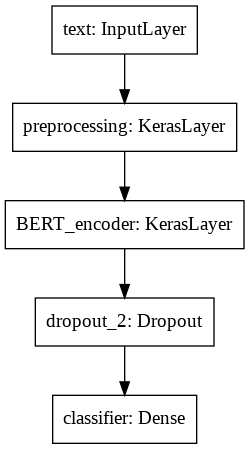

In [ ]:
# Model architecture
tf.keras.utils.plot_model(classifier_model)

### Training

We are going to train our model for 5 epochs, which is more than enough for this experiment.

In [ ]:
# Loss function
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalCrossentropy()

# compile bert model
classifier_model.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['acc'])


In [ ]:
# Training Bert
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=5)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/5
49/49 [==============================] - 31s 560ms/step - loss: 1.6849 - acc: 0.3523 - val_loss: 0.7688 - val_acc: 0.7792
Epoch 2/5
49/49 [==============================] - 27s 543ms/step - loss: 0.3925 - acc: 0.9003 - val_loss: 0.2930 - val_acc: 0.9195
Epoch 3/5
49/49 [==============================] - 26s 535ms/step - loss: 0.1311 - acc: 0.9728 - val_loss: 0.2883 - val_acc: 0.9273
Epoch 4/5
49/49 [==============================] - 27s 544ms/step - loss: 0.0917 - acc: 0.9845 - val_loss: 0.2560 - val_acc: 0.9403
Epoch 5/5
49/49 [==============================] - 26s 541ms/step - loss: 0.0491 - acc: 0.9909 - val_loss: 0.2784 - val_acc: 0.9351


### Evaluation

The final step is to evaluate the accuracy of the model on the test dataset.

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

16/16 [==============================] - 2s 144ms/step - loss: 0.2980 - acc: 0.9400
Loss: 0.2980015277862549
Accuracy: 0.9399585723876953


To predict a single sentence:

In [ ]:
preduction = classifier_model.predict(['I have fear to the ghost'])
for class_pos in preduction.argmax(axis=1):
  print(class_names[class_pos])

fear


### Save model

Finally, we are going to save our model.

In [ ]:
# Save model
classifier_model.save('bert_multi_label_classifier.h5')